In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
########################################
########################################
########################################

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# Check TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) detected: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU detected, running on CPU.")

# Enable mixed precision for better GPU performance
from tensorflow.keras.mixed_precision import Policy, set_global_policy

policy = Policy('mixed_float16')
set_global_policy(policy)
print(f"Mixed precision enabled with policy: {policy}")

# Define paths
image_dir = "/kaggle/input/428-ver3/temp/images"
mask_dir = "/kaggle/input/428-ver3/temp/augmentation"

# #small
# image_dir = "/kaggle/input/428-small/temp_small/images"
# mask_dir = "/kaggle/input/428-small/temp_small/annotations"

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Load and preprocess data
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

images = []
masks = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    img = imread(img_path)
    if len(img.shape) == 2:  # Convert grayscale to RGB
        img = np.stack((img,) * 3, axis=-1)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), preserve_range=True)

    mask = imread(mask_path, as_gray=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True)

    images.append(img)
    masks.append(mask)

images = np.array(images, dtype=np.uint8)
masks = np.expand_dims(np.array(masks, dtype=np.bool_), axis=-1)


# Split data (70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print('donee')

TensorFlow Version: 2.17.0
Error setting memory growth: Physical devices cannot be modified after being initialized
Mixed precision enabled with policy: <DTypePolicy "mixed_float16">


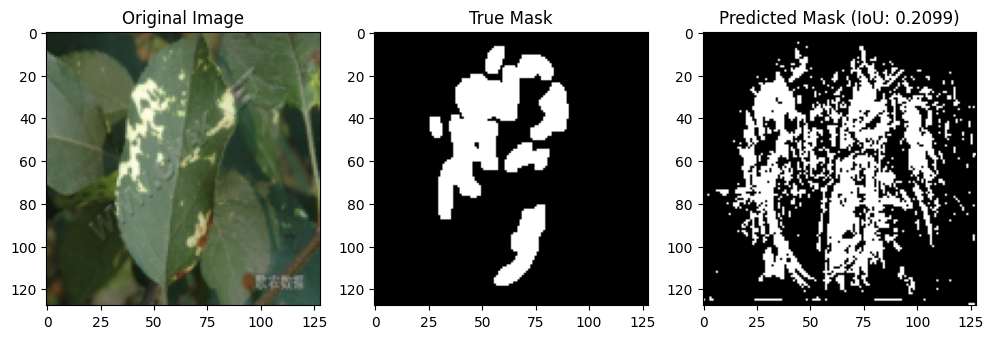

IoU for Image 251: 0.2099


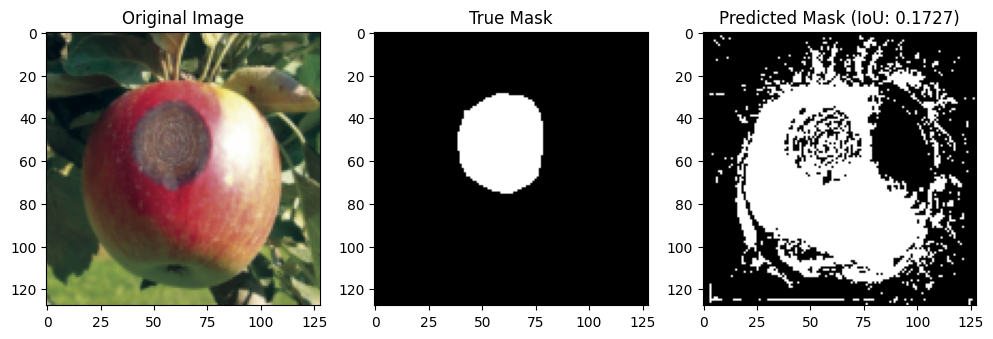

IoU for Image 520: 0.1727


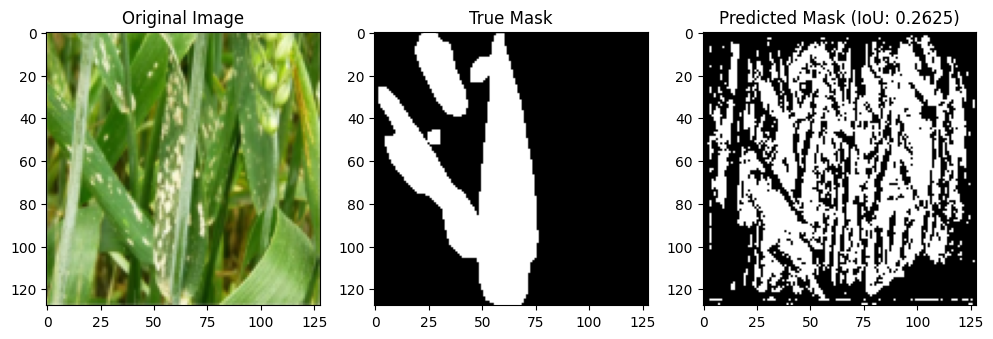

IoU for Image 1707: 0.2625


In [4]:
import random

def predict_and_evaluate_random(n=3):
    """Randomly selects 'n' images from the test set and evaluates them."""
    indices = random.sample(range(len(X_test)), n)  # Pick 'n' random indices

    for idx in indices:
        image_resized = X_test[idx]
        true_mask_resized = Y_test[idx]

        # Expand dimensions to match model input
        image_input = np.expand_dims(image_resized, axis=0)

        # Predict mask
        predicted_mask = model.predict(image_input, verbose=0)[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Test with 0.1 if needed

        # Calculate IoU
        intersection = np.logical_and(true_mask_resized, predicted_mask).sum()
        union = np.logical_or(true_mask_resized, predicted_mask).sum()
        iou = intersection / union if union != 0 else 0

        # Display results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image_resized)

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(np.squeeze(true_mask_resized), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title(f"Predicted Mask (IoU: {iou:.4f})")
        plt.imshow(np.squeeze(predicted_mask), cmap='gray')

        plt.show()

        print(f"IoU for Image {idx}: {iou:.4f}")

# Call the function to display results for 3 random images
predict_and_evaluate_random(n=3)


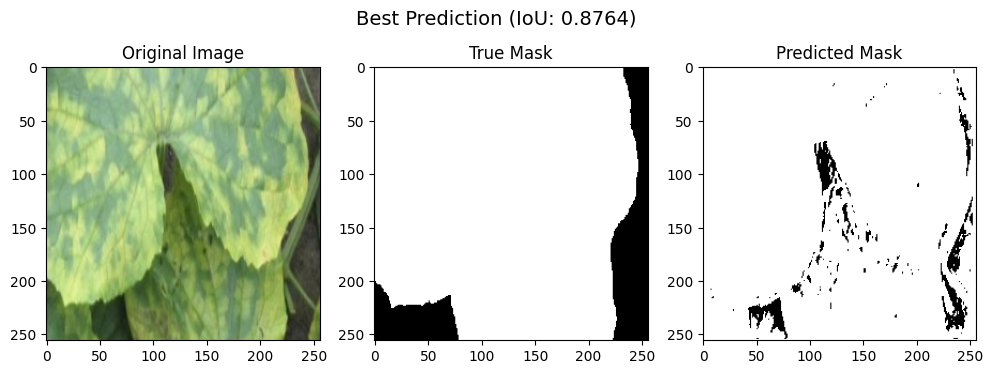

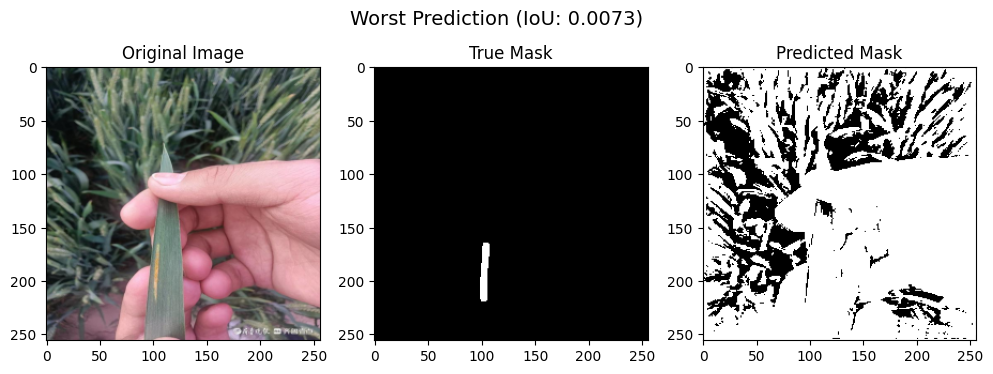

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def predict_and_evaluate_best_worst():
    """Evaluates all test images and displays the best (highest IoU) and worst (lowest IoU) predictions."""
    iou_scores = []
    predicted_masks = []

    # Iterate through all test images and store IoU scores
    for idx in range(len(X_test)):
        image_resized = X_test[idx]
        true_mask_resized = Y_test[idx]

        # Expand dimensions to match model input
        image_input = np.expand_dims(image_resized, axis=0)

        # Predict mask
        predicted_mask = model.predict(image_input, verbose=0)[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Thresholding

        # Calculate IoU
        intersection = np.logical_and(true_mask_resized, predicted_mask).sum()
        union = np.logical_or(true_mask_resized, predicted_mask).sum()
        iou = intersection / union if union != 0 else 0

        iou_scores.append((iou, idx))  # Store IoU score with index
        predicted_masks.append(predicted_mask)

    # Find best and worst IoU images
    best_idx = max(iou_scores, key=lambda x: x[0])[1]  # Index of highest IoU
    worst_idx = min(iou_scores, key=lambda x: x[0])[1]  # Index of lowest IoU

    # Function to visualize results
    def display_result(image, true_mask, pred_mask, iou, title):
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{title} (IoU: {iou:.4f})", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(np.squeeze(true_mask), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(np.squeeze(pred_mask), cmap='gray')

        plt.show()

    # Display best and worst results
    display_result(X_test[best_idx], Y_test[best_idx], predicted_masks[best_idx], max(iou_scores)[0], "Best Prediction")
    display_result(X_test[worst_idx], Y_test[worst_idx], predicted_masks[worst_idx], min(iou_scores)[0], "Worst Prediction")

# Call the function to show the best and worst predictions
predict_and_evaluate_best_worst()


# better model????

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 98s 258ms/step - accuracy: 0.6669 - loss: 0.9704 - val_accuracy: 0.7333 - val_loss: 0.5487
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - accuracy: 0.7385 - loss: 0.5374 - val_accuracy: 0.7517 - val_loss: 0.5291
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - accuracy: 0.7536 - loss: 0.5104 - val_accuracy: 0.7646 - val_loss: 0.5054
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - accuracy: 0.7590 - loss: 0.4974 - val_accuracy: 0.7737 - val_loss: 0.4910
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - accuracy: 0.7694 - loss: 0.4798 - val_accuracy: 0.7645 - val_loss: 0.4796
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - accuracy: 0.7781 - loss: 0.4642 - val_accuracy: 0.7878 - val_loss: 0.4645
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - accuracy: 0.7850 - loss: 0.4505 - val_accuracy: 0.7874 - val_loss: 0.4549
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - accuracy: 0.8007 - loss: 0

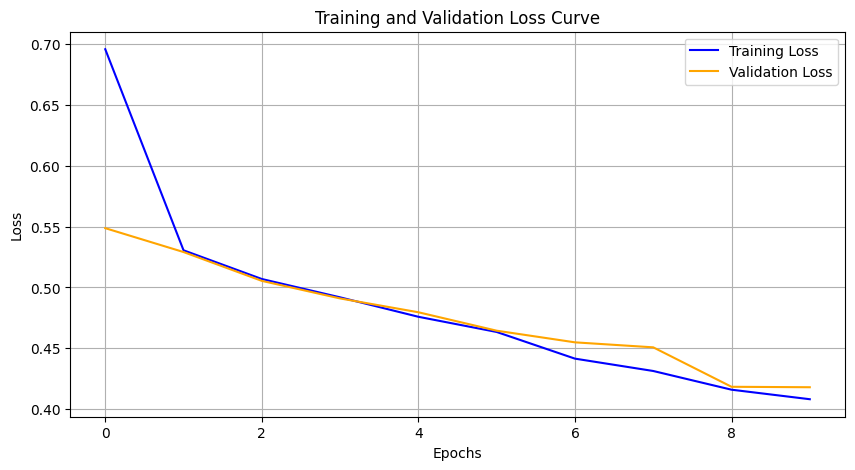

In [7]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define U-Net model with Conv2DTranspose for upsampling
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    # Encoder (Contracting Path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck (Bridge)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Expanding Path) using Conv2DTranspose
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)


# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [11]:

model.save("/kaggle/working/unet_model_final.h5")

import os
print("Model saved at:", os.path.exists("/kaggle/working/unet_model.h5"))

Model saved at: True


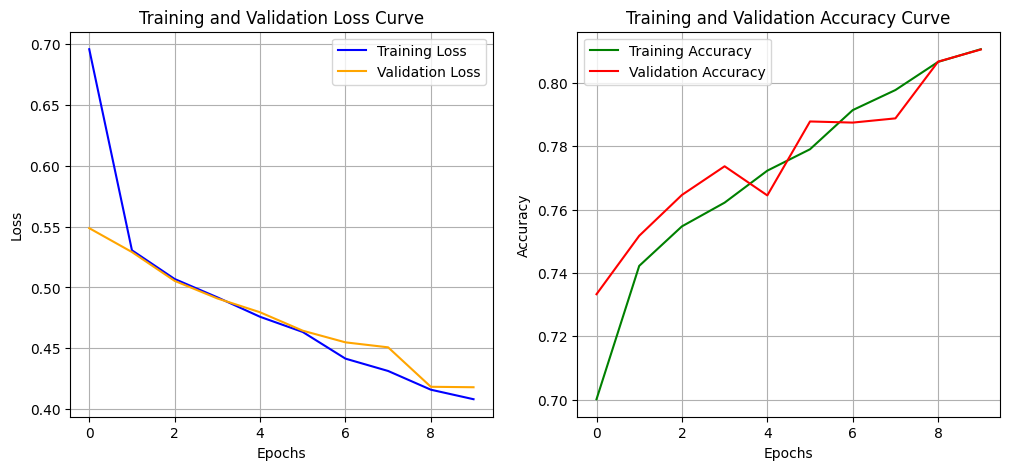

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()


In [13]:

# Evaluate on test set
results = model.evaluate(X_test, Y_test, verbose=1)

# Predict on test set
preds_test = model.predict(X_test, verbose=1)

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    y_pred = (y_pred > 0.1).astype(np.uint8)    #####
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union != 0 else 0

    dice = (2 * intersection) / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) != 0 else 0

    pixel_accuracy = (y_true == y_pred).mean()

    return iou, dice, pixel_accuracy

iou, dice, pixel_accuracy = calculate_metrics(Y_test, preds_test)

# Print results
print("Test Results:")
print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8104 - loss: 0.4164
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
Test Results:
Loss: 0.4146459698677063
Accuracy: 0.8132504224777222


In [9]:
# Assuming the ground truth and predicted masks are numpy arrays
# You should have binary masks for each class or multi-class masks
def compute_metrics(pred_mask, true_mask, num_classes):
    # Ensure the masks are flattened (1D)
    pred_mask = pred_mask.flatten()
    true_mask = true_mask.flatten()

    # Pixel Accuracy
    pixel_accuracy = np.sum(pred_mask == true_mask) / len(true_mask)

    # IoU (Intersection over Union)
    iou_list = []
    for i in range(num_classes):
        # Calculate IoU for each class
        pred_class = (pred_mask == i)
        true_class = (true_mask == i)

        intersection = np.sum(pred_class & true_class)
        union = np.sum(pred_class | true_class)

        iou = intersection / (union + 1e-6)  # Add a small epsilon to prevent division by zero
        iou_list.append(iou)

    mean_iou = np.mean(iou_list)

    # Dice Coefficient
    dice_list = []
    for i in range(num_classes):
        pred_class = (pred_mask == i)
        true_class = (true_mask == i)

        intersection = np.sum(pred_class & true_class)
        dice = (2 * intersection) / (np.sum(pred_class) + np.sum(true_class) + 1e-6)
        dice_list.append(dice)

    mean_dice = np.mean(dice_list)

    return pixel_accuracy, mean_iou, mean_dice

# Example usage with predicted and true masks
num_classes = 1  # Example: for binary segmentation, num_classes would be 2 (background, foreground)

# Generate predicted masks for the test set
pred_mask = model.predict(X_test)  # Predict segmentation for the test images
pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert probabilities to binary mask (threshold = 0.5)

# Use true masks from the test set
true_mask = np.squeeze(Y_test)  # Remove unnecessary dimensions from ground truth masks

# Compute evaluation metrics
pixel_accuracy, mean_iou, mean_dice = compute_metrics(pred_mask, true_mask, num_classes=1)

print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step
Pixel Accuracy: 0.8133
Mean IoU: 0.7850
Mean Dice Coefficient: 0.8796


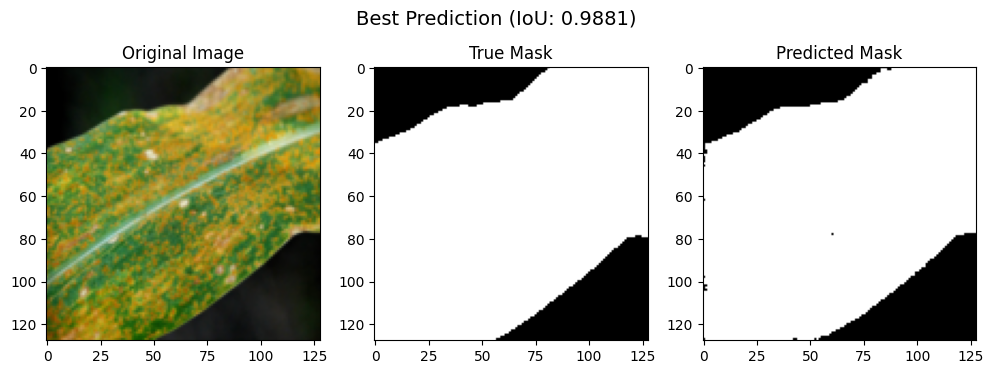

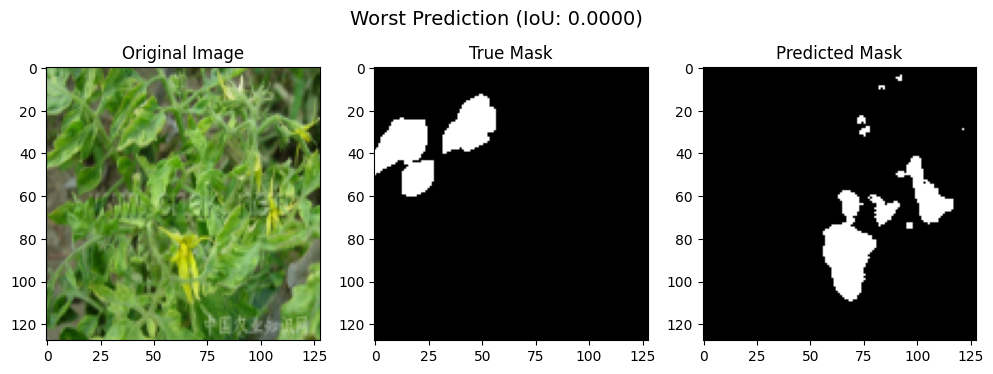

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def predict_and_evaluate_best_worst():
    """Evaluates all test images and displays the best (highest IoU) and worst (lowest IoU) predictions."""
    iou_scores = []
    predicted_masks = []

    # Iterate through all test images and store IoU scores
    for idx in range(len(X_test)):
        image_resized = X_test[idx]
        true_mask_resized = Y_test[idx]

        # Expand dimensions to match model input
        image_input = np.expand_dims(image_resized, axis=0)

        # Predict mask
        predicted_mask = model.predict(image_input, verbose=0)[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Thresholding

        # Calculate IoU
        intersection = np.logical_and(true_mask_resized, predicted_mask).sum()
        union = np.logical_or(true_mask_resized, predicted_mask).sum()
        iou = intersection / union if union != 0 else 0

        iou_scores.append((iou, idx))  # Store IoU score with index
        predicted_masks.append(predicted_mask)

    # Find best and worst IoU images
    best_idx = max(iou_scores, key=lambda x: x[0])[1]  # Index of highest IoU
    worst_idx = min(iou_scores, key=lambda x: x[0])[1]  # Index of lowest IoU

    # Function to visualize results
    def display_result(image, true_mask, pred_mask, iou, title):
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{title} (IoU: {iou:.4f})", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(np.squeeze(true_mask), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(np.squeeze(pred_mask), cmap='gray')

        plt.show()

    # Display best and worst results
    display_result(X_test[best_idx], Y_test[best_idx], predicted_masks[best_idx], max(iou_scores)[0], "Best Prediction")
    display_result(X_test[worst_idx], Y_test[worst_idx], predicted_masks[worst_idx], min(iou_scores)[0], "Worst Prediction")

# Call the function to show the best and worst predictions
predict_and_evaluate_best_worst()


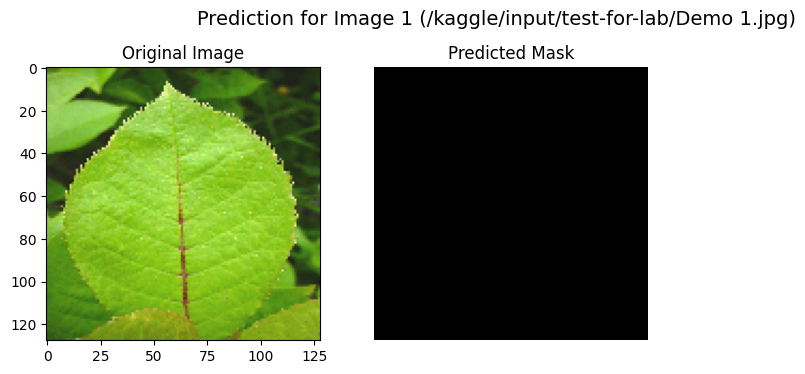

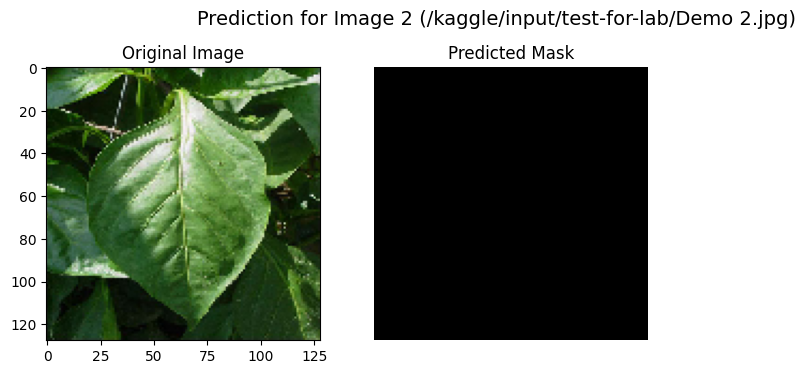

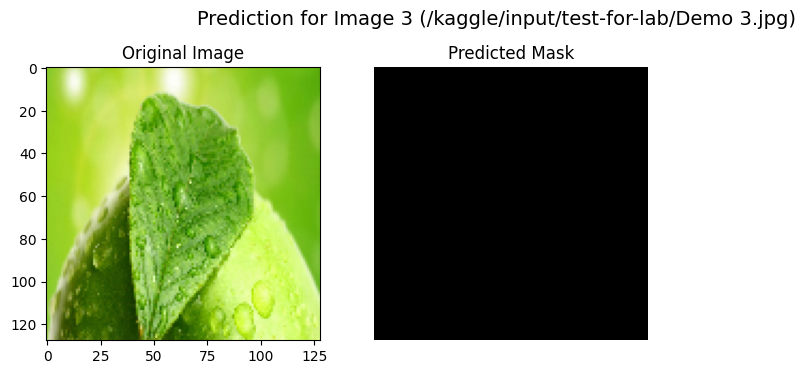

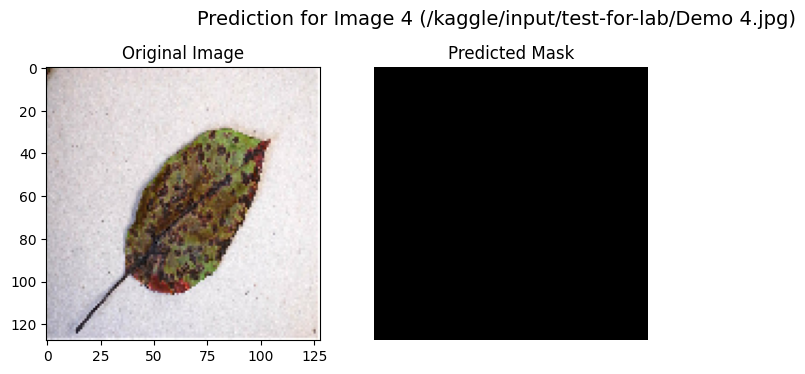

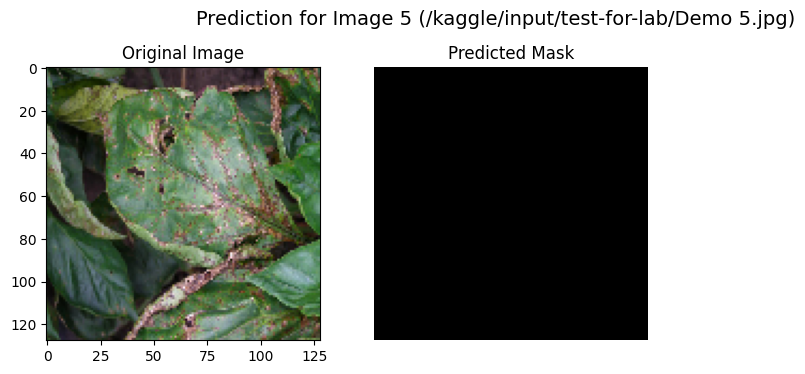

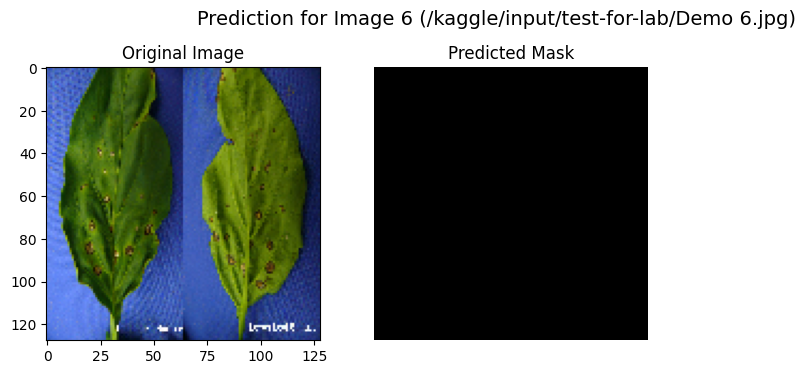

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load your trained model
model_path = '/kaggle/input/unet11/final_model.h5'  # Replace this with your actual model path
model = load_model(model_path)

def predict_and_display_images(image_paths):
    """Displays the images and their predicted masks for the provided list of image paths."""
    
    # Function to preprocess and predict mask for each image
    def preprocess_and_predict(image_path):
        image = load_img(image_path, target_size=IMG_SIZE)  # Resize image
        image_array = img_to_array(image) / 255.0  # Normalize to [0, 1]
        image_input = np.expand_dims(image_array, axis=0)  # Add batch dimension

        # Predict mask
        predicted_mask = model.predict(image_input, verbose=0)[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Thresholding
        return image_array, predicted_mask

    # Function to visualize results
    def display_result(image, pred_mask, title):
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{title}", fontsize=14)

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image)

        # Predicted Mask
        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(np.squeeze(pred_mask), cmap='gray')

        plt.axis("off")
        plt.show()

    # Iterate through the given image paths
    for i, img_path in enumerate(image_paths):
        # Preprocess image and predict mask
        image, predicted_mask = preprocess_and_predict(img_path)
        
        # Display the result for each image
        display_result(image, predicted_mask, f"Prediction for Image {i + 1} ({img_path})")

# Example image paths (provide your own paths)
image_paths = [
    "/kaggle/input/test-for-lab/Demo 1.jpg",
    "/kaggle/input/test-for-lab/Demo 2.jpg",
    "/kaggle/input/test-for-lab/Demo 3.jpg",
    "/kaggle/input/test-for-lab/Demo 4.jpg",
    "/kaggle/input/test-for-lab/Demo 5.jpg",
    "/kaggle/input/test-for-lab/Demo 6.jpg"
]

# Set your image size (adjust according to your model input size)
IMG_SIZE = (128, 128)

# Call the function to show predictions for the provided image paths
predict_and_display_images(image_paths)
